<a href="https://colab.research.google.com/github/srijabiswas-01/reinforcement-learning-trading-bot/blob/main/stock-ananlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Elite Reinforcement Learning–Based Automated Trading Agent

This notebook demonstrates the initial data analysis and environment setup
for a reinforcement learning–based stock trading agent.


In [2]:
!pip install -q yfinance pandas numpy plotly ta scipy stable-baselines3 gymnasium seaborn matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 19.7 MB/s eta 0:00:00


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
# from datetime import datetime
from datetime import datetime, timezone
datetime.now(timezone.utc)

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


np.random.seed(42)

### **Market ETFs (tradable proxies)**

In [4]:
markets = {
    "USA_S&P500": "SPY",
    "Australia_ASX200": "STW.AX",
    "UK_FTSE100": "ISF.L",
    "Japan_Nikkei225": "EWJ",
    "China_SSE": "FXI",
    "India_NIFTY50": "NIFTYBEES.NS"
}

start_date = "2015-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

market_data = {}

### **Data Download & Cleaning**

In [26]:
for market, ticker in markets.items():
    print(f"Downloading {market} ({ticker})")

    df = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        interval="1d",
        auto_adjust=False,
        progress=False
    )

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    df.dropna(subset=["Close"], inplace=True)
    df.reset_index(inplace=True)

    df = df[[
        "Date", "Open", "High", "Low",
        "Close", "Adj Close", "Volume"
    ]]

    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    market_data[market] = df

    print(f"✔ Rows: {len(df)} | Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")

✔ Rows: 2790 | Date range: 2015-01-02 → 2026-02-05
✔ Rows: 2808 | Date range: 2015-01-02 → 2026-02-05
✔ Rows: 2803 | Date range: 2015-01-02 → 2026-02-05
✔ Rows: 2790 | Date range: 2015-01-02 → 2026-02-05
✔ Rows: 2790 | Date range: 2015-01-02 → 2026-02-05
✔ Rows: 2741 | Date range: 2015-01-01 → 2026-02-05


In [6]:
market_data["USA_S&P500"].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,206.380005,206.880005,204.179993,205.429993,170.589600,121465900
1,2015-01-05,204.169998,204.369995,201.350006,201.720001,167.508835,169632600
2,2015-01-06,202.089996,202.720001,198.860001,199.820007,165.931091,209151400
3,2015-01-07,201.419998,202.720001,200.880005,202.309998,167.998734,125346700
4,2015-01-08,204.009995,206.160004,203.990005,205.899994,170.979874,147217800


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
for market, df in market_data.items():
    print(f"\n{market}")
    print("Start date :", df.index.min())
    print("End date   :", df.index.max())
    print("Rows       :", len(df))
    print("Columns    :", df.columns.tolist())


USA_S&P500
Start date : 0
End date   : 2789
Rows       : 2790
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Australia_ASX200
Start date : 0
End date   : 2807
Rows       : 2808
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

UK_FTSE100
Start date : 0
End date   : 2802
Rows       : 2803
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

Japan_Nikkei225
Start date : 0
End date   : 2789
Rows       : 2790
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

China_SSE
Start date : 0
End date   : 2789
Rows       : 2790
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

India_NIFTY50
Start date : 0
End date   : 2740
Rows       : 2741
Columns    : ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


### **Feature Engineering (RL-relevant)**

In [8]:
clean_market_data = {}

for market, df in market_data.items():

    df["Return"] = df["Adj Close"].pct_change()
    df["Volatility_20"] = df["Return"].rolling(20).std()
    df["Momentum_10"] = df["Adj Close"] / df["Adj Close"].shift(10) - 1
    df["Volume_MA20"] = df["Volume"].rolling(20).mean()

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    clean_market_data[market] = df[[
        "Date", "Close", "Volume",
        "Return", "Volatility_20",
        "Momentum_10", "Volume_MA20"
    ]]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### **Train / Test Split**

In [9]:
train_data, test_data = {}, {}
split_date = "2022-01-01"

for market, df in clean_market_data.items():
    train_data[market] = df[df["Date"] < split_date].reset_index(drop=True)
    test_data[market]  = df[df["Date"] >= split_date].reset_index(drop=True)

### **EXPLORATORY DATA ANALYSIS (EDA)**

Summary Statistics

In [10]:
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")

for market, df in clean_market_data.items():
    print("\n" + "=" * 60)
    print(f"Market: {market}")
    print(df.describe())


SUMMARY STATISTICS

Market: USA_S&P500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                                Date        Close        Volume       Return  \
count                           2770  2770.000000  2.770000e+03  2770.000000   
mean   2020-08-01 11:55:19.277978368   364.785379  8.553169e+07     0.000571   
min              2015-02-02 00:00:00   182.860001  2.027000e+07    -0.109424   
25%              2017-10-30 06:00:00   251.952503  5.874842e+07    -0.003652   
50%              2020-08-01 12:00:00   332.029999  7.549710e+07     0.000645   
75%              2023-05-02 18:00:00   446.190002  9.866798e+07     0.005916   
max              2026-02-05 00:00:00   695.489990  5.072443e+08     0.105019   
std                              NaN   134.836044  4.338685e+07     0.011180   

       Volatility_20  Momentum_10   Volume_MA20  
count    2770.000000  2770.000000  2.770000e+03  
mean        0.009357     0.005611  8.576787e+07  
min         0.002010    -0.232884  3.734529e+07  
25%         0.005718    -0.007215  6.690537e+07  
50%         0.007663     0.00

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                                Date        Close        Volume       Return  \
count                           2783  2783.000000  2.783000e+03  2783.000000   
mean   2020-08-01 18:17:58.835788800   723.088287  5.104378e+06     0.000191   
min              2015-01-30 00:00:00   492.799988  3.992370e+05    -0.115098   
25%              2017-10-30 12:00:00   682.099976  2.708232e+06    -0.004123   
50%              2020-07-31 00:00:00   723.200012  4.017121e+06     0.000539   
75%              2023-05-07 00:00:00   751.250000  6.245646e+06     0.005098   
max              2026-02-05 00:00:00  1013.400024  8.326176e+07     0.089692   
std                              NaN    79.826301  4.063575e+06     0.009715   

       Volatility_20  Momentum_10   Volume_MA20  
count    2783.000000  2783.000000  2.783000e+03  
mean        0.008515     0.001903  5.120386e+06  
min         0.003056    -0.261431  1.831409e+06  
25%         0.005784    -0.012327  3.232828e+06  
50%         0.007197     0.00

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


                                Date        Close        Volume       Return  \
count                           2770  2770.000000  2.770000e+03  2770.000000   
mean   2020-08-01 11:55:19.277978368    59.554913  7.330442e+06     0.000364   
min              2015-02-02 00:00:00    41.279999  1.370400e+06    -0.098047   
25%              2017-10-30 06:00:00    52.790001  4.615975e+06    -0.005206   
50%              2020-08-01 12:00:00    58.250000  6.311412e+06     0.000581   
75%              2023-05-02 18:00:00    67.099998  8.785675e+06     0.006179   
max              2026-02-05 00:00:00    87.489998  4.279328e+07     0.076075   
std                              NaN     8.956324  4.204552e+06     0.010962   

       Volatility_20  Momentum_10   Volume_MA20  
count    2770.000000  2770.000000  2.770000e+03  
mean        0.010038     0.003541  7.322144e+06  
min         0.002202    -0.194108  3.292920e+06  
25%         0.007288    -0.012814  5.462478e+06  
50%         0.009504     0.00

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Price Trend

In [11]:
print("\n" + "=" * 80)
print("PRICE TREND")

for market, df in clean_market_data.items():

    # Weekly resampling to avoid overplotting
    df_plot = (
        df
        .set_index("Date")
        .resample("W")
        .last()
        .reset_index()
    )

    fig = px.line(
        df_plot,
        x="Date",
        y="Close",
        title=f"{market} – Weekly Closing Price Trend (Log Scale)",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=3))
    fig.update_yaxes(type="log", title="Closing Price (Log Scale)")
    fig.update_xaxes(rangeslider_visible=True, title="Date")

    fig.show()


PRICE TREND


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Return Distribution

In [12]:
print("\n" + "=" * 80)
print("RETURN DISTRIBUTION")

for market, df in clean_market_data.items():

    fig = px.histogram(
        df,
        x="Return",
        nbins=100,
        title=f"{market} – Daily Return Distribution",
        marginal="box",
        template="plotly_white"
    )

    fig.update_xaxes(title="Daily Return")
    fig.update_yaxes(title="Frequency")

    fig.show()


RETURN DISTRIBUTION


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Volatility Regimes

In [13]:
print("\n" + "=" * 80)
print("VOLATILITY REGIMES")

for market, df in clean_market_data.items():

    df_plot = (
        df
        .set_index("Date")
        .resample("W")
        .last()
        .reset_index()
    )

    fig = px.line(
        df_plot,
        x="Date",
        y="Volatility_20",
        title=f"{market} – 20-Day Rolling Volatility",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=2.5))
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title="Volatility (20-Day)")

    fig.show()


VOLATILITY REGIMES


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Volume Behaviour

In [14]:
print("\n" + "=" * 80)
print("VOLUME BEHAVIOUR")

for market, df in clean_market_data.items():

    df_plot = (
        df
        .set_index("Date")
        .resample("W")
        .sum()
        .reset_index()
    )

    fig = px.line(
        df_plot,
        x="Date",
        y="Volume",
        title=f"{market} – Weekly Trading Volume",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=2.5))
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title="Trading Volume")

    fig.show()


VOLUME BEHAVIOUR


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



Feature Correlation (State Design Check)


FEATURE CORRELATION


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



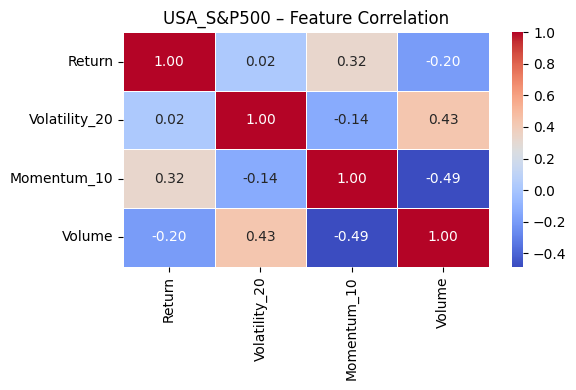

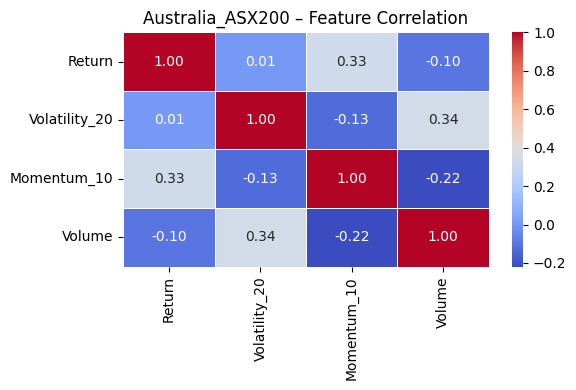

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



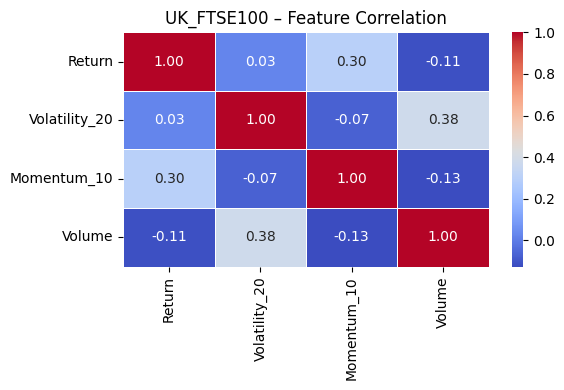

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



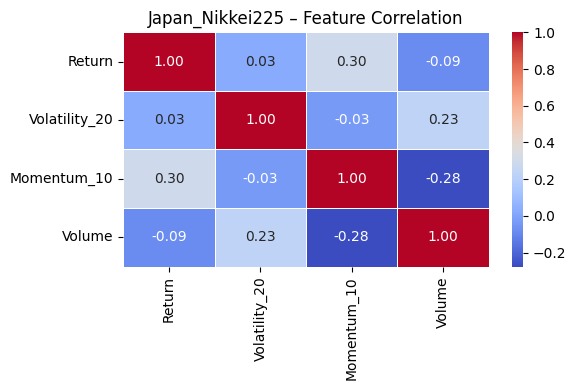

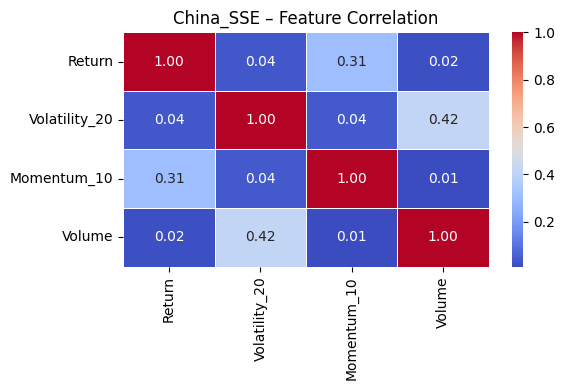

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



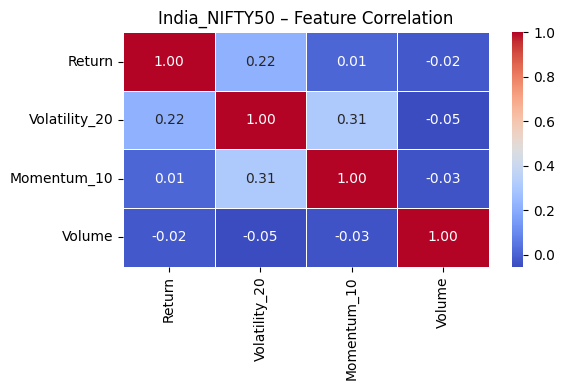

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [15]:
print("\n" + "=" * 80)
print("FEATURE CORRELATION")

features = ["Return", "Volatility_20", "Momentum_10", "Volume"]

for market, df in clean_market_data.items():

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        df[features].corr(),
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5
    )

    plt.title(f"{market} – Feature Correlation")
    plt.tight_layout()
    plt.show()

Drawdown Analysis (Risk Insight)

In [16]:
print("\n" + "=" * 80)
print("DRAWDOWN ANALYSIS")

for market, df in clean_market_data.items():

    cumulative = (1 + df["Return"]).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max

    fig = px.line(
        x=df["Date"],
        y=drawdown,
        title=f"{market} – Drawdown Analysis",
        template="plotly_white"
    )

    fig.update_traces(line=dict(width=2.5))
    fig.update_yaxes(title="Drawdown")
    fig.update_xaxes(rangeslider_visible=True)

    fig.show()


DRAWDOWN ANALYSIS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [17]:
for market, df in clean_market_data.items():
    print("\n" + "="*50)
    print(f"Market: {market}")
    print(df.describe())


Market: USA_S&P500
                                Date        Close        Volume       Return  \
count                           2770  2770.000000  2.770000e+03  2770.000000   
mean   2020-08-01 11:55:19.277978368   364.785379  8.553169e+07     0.000571   
min              2015-02-02 00:00:00   182.860001  2.027000e+07    -0.109424   
25%              2017-10-30 06:00:00   251.952503  5.874842e+07    -0.003652   
50%              2020-08-01 12:00:00   332.029999  7.549710e+07     0.000645   
75%              2023-05-02 18:00:00   446.190002  9.866798e+07     0.005916   
max              2026-02-05 00:00:00   695.489990  5.072443e+08     0.105019   
std                              NaN   134.836044  4.338685e+07     0.011180   

       Volatility_20  Momentum_10   Volume_MA20  
count    2770.000000  2770.000000  2.770000e+03  
mean        0.009357     0.005611  8.576787e+07  
min         0.002010    -0.232884  3.734529e+07  
25%         0.005718    -0.007215  6.690537e+07  
50%      

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [18]:
for market, df in train_data.items():
    df["Volume_MA20"] = df["Volume"].rolling(20).mean()
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

## **Environment Code**

In [19]:
class TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, df, risk_penalty=0.001):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.risk_penalty = risk_penalty

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_idx = 0
        self.position = 0
        self.portfolio_value = 1.0
        self.prev_price = self.df.loc[self.step_idx, "Close"]
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.df.loc[self.step_idx]
        volume_norm = row["Volume"] / (row["Volume_MA20"] + 1e-8)

        return np.array([
            row["Return"],
            row["Volatility_20"],
            row["Momentum_10"],
            volume_norm,
            self.position
        ], dtype=np.float32)

    def step(self, action):
        current_price = self.df.loc[self.step_idx, "Close"]

        if action == 1:
            self.position = 1
        elif action == 2:
            self.position = -1

        price_change = (current_price - self.prev_price) / self.prev_price
        portfolio_return = self.position * price_change

        reward = (
            100 * portfolio_return
            - 10 * self.risk_penalty * self.df.loc[self.step_idx, "Volatility_20"]
        )

        self.portfolio_value *= (1 + portfolio_return)

        self.prev_price = current_price
        self.step_idx += 1

        done = self.step_idx >= len(self.df) - 1
        obs = self._get_obs() if not done else np.zeros(5)

        return obs, reward, done, False, {"portfolio_value": self.portfolio_value}

### **PPO Training (MULTI-MARKET)**

In [20]:
# env = DummyVecEnv([
#     lambda: TradingEnv(train_data["USA_S&P500"])
# ])

# model = PPO(
#     "MlpPolicy",
#     env,
#     learning_rate=3e-4,
#     n_steps=2048,
#     batch_size=64,
#     gamma=0.99,
#     verbose=1
# )

# model.learn(total_timesteps=200_000)


from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# --------------------------------------------------
# Create one environment per market
# --------------------------------------------------

def make_env(market_name):
    return lambda: TradingEnv(train_data[market_name])

env = DummyVecEnv([
    make_env(market) for market in train_data.keys()
])

print(f"Training PPO on {len(train_data)} markets:")
for m in train_data.keys():
    print("•", m)

# --------------------------------------------------
# PPO Model
# --------------------------------------------------

model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    verbose=1
)

# --------------------------------------------------
# Train
# --------------------------------------------------

model.learn(total_timesteps=400_000)

Training PPO on 6 markets:
• USA_S&P500
• Australia_ASX200
• UK_FTSE100
• Japan_Nikkei225
• China_SSE
• India_NIFTY50
Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning:

You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



------------------------------
| time/              |       |
|    fps             | 2381  |
|    iterations      | 1     |
|    time_elapsed    | 5     |
|    total_timesteps | 12288 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1295        |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.005638499 |
|    clip_fraction        | 0.0206      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.000639    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.39e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00228    |
|    value_loss           | 483         |
-----------------------------------------
---------------------------

In [21]:
def cagr(returns):
    cum = (1 + returns).cumprod()
    years = len(returns) / 252
    return cum.iloc[-1] ** (1 / years) - 1

def max_dd(returns):
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    return ((cum - peak) / peak).min()

def sharpe(returns):
    return np.sqrt(252) * returns.mean() / returns.std()

In [24]:
results = []

for market in test_data.keys():
    env_test = TradingEnv(test_data[market])
    obs, _ = env_test.reset()

    curve = []
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env_test.step(action)
        curve.append(info["portfolio_value"])

    rl_returns = pd.Series(curve).pct_change().dropna()
    bh_returns = test_data[market]["Return"].iloc[:len(rl_returns)]

    results.append({
        "Market": market,
        "RL_Final": curve[-1],
        "BH_Final": (1 + bh_returns).cumprod().iloc[-1],
        "RL_CAGR": cagr(rl_returns),
        "BH_CAGR": cagr(bh_returns),
        "RL_Sharpe": sharpe(rl_returns),
        "BH_Sharpe": sharpe(bh_returns),
        "RL_MaxDD": max_dd(rl_returns),
        "BH_MaxDD": max_dd(bh_returns)
    })

results_df = pd.DataFrame(results)
results_df

,Market,RL_Final,BH_Final,RL_CAGR,BH_CAGR,RL_Sharpe,BH_Sharpe,RL_MaxDD,BH_MaxDD
0,USA_S&P500,2.931183e+03,1.534766,6.118446,0.111064,15.377692,0.678430,-0.002155,-0.244964
1,Australia_ASX200,4.293126e+02,1.398601,3.400582,0.085453,16.685720,0.704683,-0.005110,-0.148243
2,UK_FTSE100,2.562677e+02,1.397517,2.884289,0.085333,14.864438,0.713995,-0.002419,-0.131797
3,Japan_Nikkei225,6.491208e+03,1.431179,7.655142,0.092139,17.706235,0.576376,-0.006114,-0.280621
4,China_SSE,3.019150e+06,1.168647,38.183513,0.039059,15.850318,0.278826,-0.008738,-0.460929
5,India_NIFTY50,2.863522e+02,1.550881,3.102125,0.115707,16.923717,0.954442,-0.002120,-0.157350


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [27]:
ACTION_MAP = {0: "HOLD", 1: "BUY", 2: "SELL"}

def build_state_from_market(df, position):
    row = df.iloc[-1]
    volume_norm = row["Volume"] / (row["Volume_MA20"] + 1e-8)

    return np.array([
        row["Return"],
        row["Volatility_20"],
        row["Momentum_10"],
        volume_norm,
        position
    ], dtype=np.float32)

def trading_agent_response(model, market_name, current_position):
    df = clean_market_data[market_name]
    state = build_state_from_market(df, current_position)
    action, _ = model.predict(state.reshape(1, -1), deterministic=True)

    return {
        "Market": market_name,
        "Suggested_Action": ACTION_MAP[int(action)],
        "Current_Position": current_position,
        "Timestamp": datetime.now(timezone.utc).isoformat()
    }

# =========================================================
# CLI (MULTI-MARKET AGENT)
# =========================================================
def agent_cli(model):
    print("\n=== Elite RL Trading Agent (CLI) ===\n")
    print("Available Markets:")
    for m in clean_market_data.keys():
        print("•", m)

    while True:
        market = input("\nEnter market name (or 'exit'): ").strip()
        if market.lower() == "exit":
            print("Exiting agent.")
            break

        if market not in clean_market_data:
            print("Invalid market. Try again.")
            continue

        try:
            position = int(input("Current position (-1 short, 0 flat, 1 long): ").strip())
            response = trading_agent_response(model, market, position)

            print("\n=== AGENT RESPONSE ===")
            for k, v in response.items():
                print(f"{k}: {v}")

        except Exception as e:
            print("Error:", e)

# =========================================================
# RUN AGENT
# =========================================================
agent_cli(model)


=== Elite RL Trading Agent (CLI) ===

Available Markets:
• USA_S&P500
• Australia_ASX200
• UK_FTSE100
• Japan_Nikkei225
• China_SSE
• India_NIFTY50

Enter market name (or 'exit'): Australia_ASX200
Current position (-1 short, 0 flat, 1 long): 0

=== AGENT RESPONSE ===
Market: Australia_ASX200
Suggested_Action: SELL
Current_Position: 0
Timestamp: 2026-02-06T09:56:13.886919+00:00

Enter market name (or 'exit'): exit
Exiting agent.
